In [1]:
%matplotlib inline

import numpy as np
import scipy.stats as stats

from scipy.special import gammaln
from matplotlib import pyplot as plt

import delfi.generator as dg
import delfi.distribution as dd
from delfi.utils.viz import plot_pdf
import delfi.inference as infer
from delfi.summarystats.Identity import Identity

from snl.util.plot import plot_hist_marginals
from lfimodels.snl_exps.util import  save_results_byname, load_results_byname
from lfimodels.rockpaperscissors.rps_sde import rps_sde

model_id = 'rps'
save_path = 'results/' + model_id



seed = 42

L = 100  # image rows/columns
duration = 100.0
dt = 1.0

nseeds = 10

use_maf = False

/opt/anaconda3/lib/python3.7/site-packages/theano/gpuarray/dnn.py:184: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
  warnings.warn("Your cuDNN version is more recent than "
Using cuDNN version 7401 on context None
Mapped name None to device cuda: GeForce RTX 2080 (0000:42:00.0)


In [2]:
# simulation setup
setup_opts = {
    'n_bypass': 0,
    'filter_sizes': [3,3,3,3, 2, 2],
    'n_filters':    (8,8,8,16,32,32),
    'pool_sizes':   [1,3,2,2, 2, 1],
    'n_hiddens': [50, 50],
    'reg_lambda': 0.01,
    'pilot_samples': 0,  # values are already between 0 and 1
    'verbose': True,
    'prior_norm': False,  # turn off till we've fixed the active trainer. good for uniform priors etc.
    'init_norm': False,
    'input_shape': (3,L,L),
    'verbose': True,
}
if use_maf:
    setup_opts.update(dict(density='maf', maf_mode='random', n_mades=5, maf_actfun='tanh', batch_norm=False))
else:
    setup_opts.update(dict(density='mog', n_components=1, svi=False))                 

run_opts = {
    'n_train': 1000,
    'n_rounds': 10,
    'minibatch': 10,
    'epochs': 2000,
    'moo': 'resample',
    'proposal': 'discrete',
    'n_null': None,
    'train_on_all': True,
    'max_norm': 0.1,
    'val_frac': 0.1,
    'silent_fail': False,
}

In [3]:
# define a function for showing simulation results as images
def showsim(s_rgb, **kwargs):
    if 'interpolation' not in kwargs.keys():
        kwargs['interpolation'] = 'None'
    s_ryb = s_rgb.copy().reshape(3, L, L)
    s_ryb[0] = np.minimum(1.0, s_ryb[0] + s_ryb[1])
    imobj = plt.imshow(np.moveaxis(s_ryb, 0, -1), **kwargs)
    plt.gca().axis('off')
    return imobj

In [4]:
def init_all(seed, pars_true=None, infobj=infer.SNPEC):
    p = dd.Uniform(lower=np.array([-1, -1, -6], dtype=float), 
                   upper=np.array([1, 1, -5], dtype=float), seed=seed)
    n_cores = 8    
    mlist = [rps_sde(dt=dt, duration=duration, L=L, seed=seed + 100 + i) for i in range(n_cores)]
    g = dg.MPGenerator(models=mlist, prior=p, summary=Identity(seed=seed+2), seed=seed+3)
    
    #m = rps_sde(dt=dt, duration=duration, L=L, seed=seed+1)
    #g = dg.Default(model=m, prior=p, summary=Identity(seed=seed+2), seed=seed+3)
    
    if pars_true is None:
        pars_true = g.prior.gen(1).reshape(-1)
    #obs = g.model.gen_single(pars_true)
    obs = g.models[0].gen_single(pars_true)
    obs_stats = g.summary.calc([obs])
    
    inf = infobj(generator=g, obs=obs_stats, seed=seed+4, **setup_opts)
    
    return g, pars_true, obs, obs_stats, inf

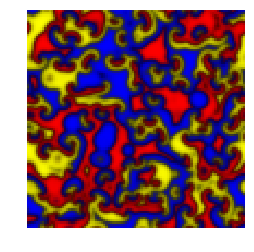

In [20]:
pars_true = np.array([-0.5, 0.5, -5.25])

g, pars_true, obs, obs_stats, inf = init_all(seed, pars_true=pars_true)

showsim(obs_stats)

In [6]:
# print the network structure. "None" indicates the batch dimension
for s in inf.network.layer:
    if s.startswith('mixture'):
        continue
    print('{0}: {1}'.format(s, inf.network.layer[s].output_shape))

input: (None, 30000)
missing: (None, 30000)
reshape: (None, 3, 100, 100)
conv_1: (None, 8, 100, 100)
conv_2: (None, 8, 98, 98)
pool_2: (None, 8, 32, 32)
conv_3: (None, 8, 30, 30)
pool_3: (None, 8, 15, 15)
conv_4: (None, 16, 13, 13)
pool_4: (None, 16, 6, 6)
conv_5: (None, 32, 5, 5)
pool_5: (None, 32, 2, 2)
conv_6: (None, 32, 1, 1)
flatten: (None, 32)


In [7]:
log, trn_data, posteriors = inf.run(**run_opts)

KeyboardInterrupt: 

NameError: name 'log' is not defined

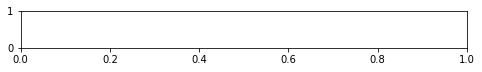

In [8]:
fig_conv = plt.figure(figsize=(8, 8))
for r in range(run_opts['n_rounds']):
    plt.subplot(run_opts['n_rounds'], 1, r + 1)
    plt.plot(log[r]['loss'],'b',label='training loss')
    plt.plot(log[r]['val_loss_iter'], log[r]['val_loss'], 'm', label='validation loss')
    plt.legend()

/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


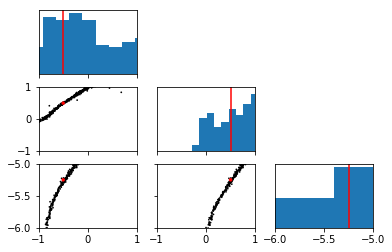

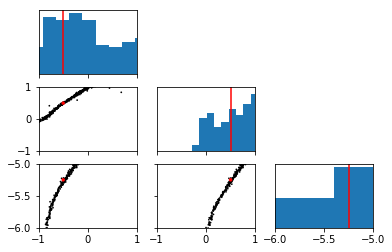

In [18]:
plot_hist_marginals(posteriors[-1].gen(1000), lims=np.vstack((g.prior.lower, g.prior.upper)).T, 
                            gt=pars_true.flatten(), rasterized=False)

In [10]:
labels_params = ['$\log_{10}(\mu)$', '$\log_{10}(\sigma)$', '$\log_{10}(D)$'] 
# all pairwise marginals of fitted posterior
fig_posterior, _ = plot_pdf(posteriors[-1], lims=[[-1, 1], [-1, 1], [-7, -5]], gt=pars_true.reshape(-1), figsize=(8, 8), resolution=100,
                  labels_params=labels_params, ticks=True)

AttributeError: 'MAFconditional' object has no attribute 'ndim'

Text(0.5,0,'Number of simulations (log scale)')

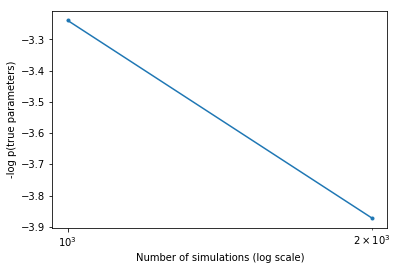

In [55]:
fig_nlogptrue = plt.figure()

nsim = (np.arange(run_opts['n_rounds']) + 1.0) * run_opts['n_train']

plt.semilogx(nsim, [-pp.eval(pars_true.reshape(1, -1), log=True) for pp in posteriors],'.-')
plt.ylabel('-log p(true parameters)')
plt.xlabel('Number of simulations (log scale)')

In [56]:
# draw samples from the prior and posterior
n_samples = 5

g.proposal = None
x_prior = g.gen(n_samples)[1]
x_posterior = np.stack([y[0]['data'] for y in g.model.gen(posteriors[-1].gen(n_samples))], axis=0)

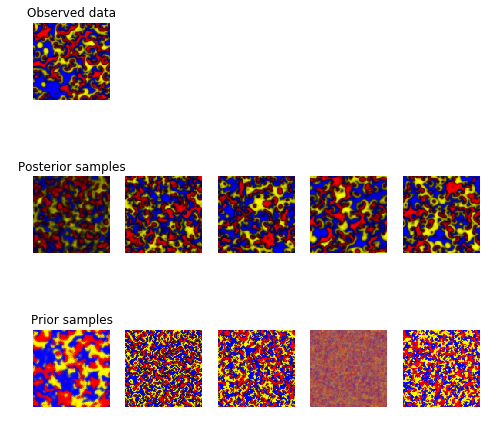

In [57]:
fig_samples = plt.figure(figsize=(8, 8))
plt.subplot(3, n_samples, 1)
showsim(obs_stats)
plt.title('Observed data')
for i in range(n_samples):
    plt.subplot(3, n_samples, n_samples + i + 1)
    showsim(x_posterior[i])
    if i == 0:
        plt.title('Posterior samples')
    plt.subplot(3, n_samples, 2 * n_samples + i + 1)
    showsim(x_prior[i])
    if i == 0:
        plt.title('Prior samples')

In [48]:
fig_posterior.savefig('rps_posterior.pdf')
fig_samples.savefig('rps_samples.pdf')
fig_nlogptrue.savefig('rps_nlogptrue.pdf')

!pdftk rps_posterior.pdf rps_samples.pdf rps_nlogptrue.pdf cat output rps.pdf
!rm rps_posterior.pdf
!rm rps_samples.pdf
!rm rps_nlogptrue.pdf

In [5]:
seeds = seed + np.arange(nseeds) * 20

In [ ]:
# run multiple seeds with SNPEC discrete MDN
for s in seeds:
    _, pt, o, os, nextinf = init_all(s)  # samples observed data from the marginal (i.e. with parameters from the prior)
    ll, _, pp = nextinf.run(**run_opts)
    
    exp_id = 'rps_' + setup_opts['density'] + '_' + str(s)
    save_results_byname(logs=ll, posteriors=pp, raw_data=o, pars_true=pt, seed=s,
                        setup_opts=setup_opts, run_opts=run_opts, exp_id=exp_id, path=save_path)

In [ ]:
run_opts_SNPEA = {
    'n_train': 1000,
    'n_rounds': 10,
    'minibatch': 100,
    'epochs': 2000,
    'max_norm': 0.1,
    'val_frac': 0.1,
    'silent_fail': False,
    'reuse_prior_samples': False,
}

In [ ]:
# run multiple seeds with SNPEA MDN
for s in seeds:
    
    _, pt, o, os, nextinf = init_all(s, infobj=infer.CDELFI)  # samples observed data from the marginal (i.e. with parameters from the prior)
    ll, _, pp = nextinf.run(**run_opts_SNPEA)
    
    exp_id = 'rps_' + setup_opts['density'] + '_' + str(s) + '_A'
    save_results_byname(logs=ll, posteriors=pp, raw_data=o, pars_true=pt, seed=s,
                        setup_opts=setup_opts, run_opts=run_opts, exp_id=exp_id, path=save_path)

In [ ]:
#load results
posteriors_seeds, pars_true_seeds = [], []
posteriors_seeds_A, pars_true_seeds_A = [], []
for s in seeds:
    exp_id = 'rps_' + setup_opts['density'] + '_' + str(s)
    pp, load_vars = load_results_byname(exp_id)
    posteriors_seeds.append(pp)
    pars_true_seeds.append(load_vars['pars_true'])
    
    exp_id = 'rps_' + setup_opts['density'] + '_' + str(s) + '_A'
    pp, load_vars = load_results_byname(exp_id)
    posteriors_seeds_A.append(pp)
    pars_true_seeds_A.append(load_vars['pars_true'])

In [ ]:
nsim = (np.arange(run_opts['n_rounds']) + 1.0) * run_opts['n_train']
fig_nlogptrue = plt.figure()

Pmat = np.array([[-pp.eval(pt.reshape(1, -1), log=True)[0] for pp in P] for P, pt in zip (posteriors_seeds, pars_true_seeds)]).T
Pmat_A = np.array([[-pp.eval(pt.reshape(1, -1), log=True)[0] for pp in P] for P, pt in zip (posteriors_seeds_A, pars_true_seeds_A)]).T

sem = Pmat.std(axis=1) / np.sqrt(Pmat.shape[1])
meanlog = Pmat.mean(axis=1)
sem_A = Pmat_A.std(axis=1) / np.sqrt(Pmat_A.shape[1])
meanlog_A = Pmat_A.mean(axis=1)

plt.fill_between(nsim, meanlog_A-sem_A, meanlog_A+sem_A, color='c', alpha=0.3)
plt.fill_between(nsim, meanlog-sem, meanlog+sem, color='k', alpha=0.3)
h = plt.plot(nsim, Pmat.mean(axis=1),'k.-', label='APT')
hA = plt.plot(nsim, Pmat.mean(axis=1),'c>-', label='SNPE-A')

plt.ylabel('-log p(true parameters)')
plt.xlabel('Number of simulations (log scale)')
plt.legend(loc='best')